In [1]:
# Import packages
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl 
from scipy.integrate import odeint
import seaborn as sns

colors=sns.color_palette("Set2")
sns.palplot(sns.color_palette("Set2"))

# Figure Size Setting
def set_fig_size(fig_width_pt,nrow=1,ncol=1):
    #Ysize_over_Xsize=(np.sqrt(5)-1)/2
    Ysize_over_Xsize=3/4

    fig_width_in = fig_width_pt/72.27
    
    fig_height_in=fig_width_in*Ysize_over_Xsize*(nrow/ncol)
    fig_dim = (fig_width_in, fig_height_in)
    return fig_dim

# these numbers come from the latex document
# using the commands 
#\showthe\columnwidth
# \showthe\textwidth
colwidth=229.5
textwidth=469


%matplotlib inline

# FIGURE STYLING
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

mpl.rcParams['axes.linewidth'] = 0.5 
mpl.rcParams['xtick.major.size'] = 3
mpl.rcParams['ytick.major.size'] = 3

mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['ytick.major.width'] = 0.5

mpl.rcParams['xtick.minor.size']=0
mpl.rcParams['ytick.minor.size']=0


mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['axes.labelsize'] = 9
mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 6
mpl.rcParams['legend.fontsize'] = 7
mpl.rcParams['font.family'] = ['sans-serif']
mpl.rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

# Panel A of the figure
In the limiting case when the receptor dynamics equilibriates instantaneously, we have that the response time of the receptor is given by
\begin{equation}
\mathcal{T}_{Y^{*}} \approx \frac{1}{k_3 + k_4 + k_5 \frac{k_1 S X_T}{k_1 S + k_2} + k_6 \frac{k_2 X_T}{k_1 S + k_2}}
\end{equation}

Re-arranging terms, we obtain that
\begin{equation}
\mathcal{T}_{Y^{*}} \approx \frac{\frac{S}{k_3 + k_4 + k_5 X_T} + \frac{k_2}{k_1(k_3 + k_4 + k_5 X_T)}}{S + \frac{k_2}{k_1}\frac{k_3 + k_4 + k_6 X_T}{k_3 + k_4 + k_5 X_T}}.
\end{equation}

This is a classical dose response curve! It has the same EC50 as $\Theta_{Y^{*}}$.

At $S=0$, the timescale is 
\begin{equation}
\mathcal{T}_0 = \frac{1}{k_3 + k_4 + k_6 X_T}.
\end{equation}


At $S>>\Theta_{Y^{*}}$, we obtain
\begin{equation}
\mathcal{T}_{\infty} = \frac{1}{k_3 + k_4 + k_5 X_T}.
\end{equation}

For concerted model, these two are exactly same! So there is no dose response dependency.


** HOW DO WE MAKE PLOTS**

- Our x-axis variable is $k_1 S / k_2$, which is stimulus/binding affinity.
- We keep same $k_1 S / k_2$ as we vary $k_1 S / k_2$.
- Suppose $s = k_1 S / k_2$. Then $k_1 S + k_2 = k_2 (1+s)$.
- We know the response time at EC50. Let us make sure that $k_2 (1+s)$ is much greater than that. To this end, we assume that $k_2 (1+s) = \frac{1}{2} \left(\frac{1}{k_3 + k_4 + k_6 X_T}+\frac{1}{k_3 + k_4 + k_5 X_T}\right)$. Thus for a given $s$, we can compute $k_2$.
- Just to keep things simple, we assume same initial condition.

# Code for analytical min, max, and difference for receptor

In [2]:
def Xpmin(lamA,lamB):
    num=np.exp(10**lamA)-1
    den=np.exp(10**lamA+10**lamB)-1
    return num/den

def Xpmax(lamA,lamB):
    num=np.exp(10**lamB)-1
    den=np.exp(10**lamA+10**lamB)-1
    return 1-num/den


def Xpdiff(lamA,lamB):
    num=(np.exp(10**lamA)-1)*(np.exp(10**lamB)-1)
    den=np.exp(10**lamA+10**lamB)-1
    return num/den

lamAarray=np.linspace(-2,2,201)
lamBarray=np.linspace(-2,2,201)

lamAA,lamBB=np.meshgrid(lamAarray,lamBarray)

Xpminarray=Xpmin(lamAA,lamBB)
Xpmaxarray=Xpmax(lamAA,lamBB)
Xpdiffarray=Xpdiff(lamAA,lamBB)

# Code for receptor dynamics

In [3]:
def pulseON(X, t,pars):
    k1,k2,S = pars
    dX = k1*S*(1-X) - k2*X
    return dX

def pulseOFF(X, t,pars):
    k1,k2,S = pars
    dX = - k2*X
    return dX

def numPulses(Ton,Toff,tmax):
    return np.ceil(tmax/(Ton+Toff)).astype('int')


def solODEConstant(k1, k2, S, Ton, Toff, tmax):
    tvals=np.linspace(0,tmax,1001)
    sol=sp.integrate.odeint(pulseON,[0],tvals,args=([k1, k2, S],),mxstep=100000)
    return tvals,sol

def solODEConstantNorm(k1, k2, S, Ton, Toff, tmax):
    tsol,xsol=solODEConstant(k1, k2, S, Ton, Toff, tmax)
    xssConst=k1*S/(k1*S+k2)
    xssnorm=xsol/xssConst
    return tsol,xssnorm
    



def solODEPulse(k1, k2, S, Ton, Toff, tmax):
    num_of_pulses = numPulses(Ton,Toff,tmax)
    
    X0min=np.zeros(num_of_pulses)
    X0max=np.zeros(num_of_pulses)
    tsol=np.array([0])
    xsol=np.array([X0min[0]])
    Ssol=np.array([0])
    
    for idx in range(0,num_of_pulses):
        tstart=idx*(Ton+Toff)
        t_during_ON = np.linspace(0,Ton,1001)
        t_during_OFF = np.linspace(0,Toff,1001)
        Stimulus_during_ON=S*np.ones(len(t_during_ON))
        Stimulus_during_OFF=np.zeros(len(t_during_ON))

        
        sol_during_ON = sp.integrate.odeint(pulseON,X0min[idx],t_during_ON,args=([k1, k2, S],),mxstep=100000)
        t_shifted_ON = tstart*np.ones(len(t_during_ON)) + t_during_ON
        X0max[idx]=sol_during_ON[-1]
        
        
        sol_during_OFF = sp.integrate.odeint(pulseOFF,X0max[idx],t_during_OFF,args=([k1, k2, S],),mxstep=100000)
        t_shifted_OFF = (tstart+Ton)*np.ones(len(t_during_OFF)) + t_during_OFF
        if idx<num_of_pulses-1:
            X0min[idx+1] = sol_during_OFF[-1]
            
        
        tsol = np.concatenate((tsol,t_shifted_ON[1:], t_shifted_OFF[1:]))
        xsol = np.concatenate((xsol,sol_during_ON[1:].flatten(), sol_during_OFF[1:].flatten()))
        Ssol = np.concatenate((Ssol,Stimulus_during_ON[1:], Stimulus_during_OFF[1:]))
    
    return tsol,xsol,Ssol

def solODEPulseNorm(k1, k2, S, Ton, Toff, tmax):
    tsol,xsol,Ssol=solODEPulse(k1, k2, S, Ton, Toff, tmax)
    xssConst=k1*S/(k1*S+k2)
    xssnorm=xsol/xssConst
    return tsol,xssnorm,Ssol


# fixed parameters
k1 = 1
k2 = 1
S = 1
tmax = 12

# changing parameters
TonFast=1/4
ToffFast=1/4

TonMod=1
ToffMod=1

TonSlow=4
ToffSlow=4


aFast=np.log10(TonFast*(k1*S+k2))
bFast=np.log10(ToffFast*k2)


aMod=np.log10(TonMod*(k1*S+k2))
bMod=np.log10(ToffMod*k2)

aSlow=np.log10(TonSlow*(k1*S+k2))
bSlow=np.log10(ToffSlow*k2)


tsolConst1,xsolConst1 = solODEConstantNorm(k1, k2, S, TonFast, ToffFast, tmax)
tsolConst2,xsolConst2 = solODEConstant(k1, k2, S/2, TonFast, ToffFast, tmax)
xsolConst2normtoS=((k1*S+k2)/(k1*S))*xsolConst2



tsolFast,xsolFast,SsolFast=solODEPulseNorm(k1, k2, S, TonFast, ToffFast, tmax)
tsolSlow,xsolSlow,SsolSlow=solODEPulseNorm(k1, k2, S, TonSlow, ToffSlow, tmax)
tsolMod,xsolMod,SsolMod=solODEPulseNorm(k1, k2, S, TonMod, ToffMod, tmax)

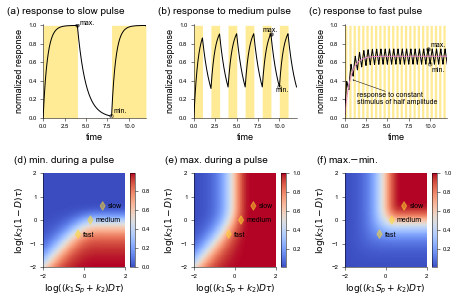

In [14]:
fig, axs = plt.subplots(2, 3,figsize=(469/72.27,2*469/3/72.27))



# figures for timeseries data
#axs[0,0].plot(tsolConst1,xsolConst1,color='k')
axs[0,0].plot(tsolSlow,xsolSlow,linewidth=1,color='k')
axs[0,0].fill_between(tsolSlow,SsolSlow,color=colors[5],linewidth=0.1,alpha=0.5)




axs[0,0].text(4.2,1,'max.',fontsize=7)
axs[0,0].text(8.2,0.05,'min.',fontsize=7)
axs[0,0].scatter([4],[Xpmax(aSlow,bSlow)],marker='o',s=12,color='k',alpha=0.5)
axs[0,0].scatter([8],[Xpmin(aSlow,bSlow)],marker='o',facecolors='none',s=12,color='k',alpha=0.5)


axs[0,0].text(-0.35,1.1,'(a) response to slow pulse',transform=axs[0,0].transAxes,fontsize=10)

axs[0,0].set_xlabel('time')
axs[0,0].set_ylabel('normalized response')
axs[0,0].set_ylim(0,1.02)
axs[0,0].set_xlim(0,12)



axs[0,1].plot(tsolMod,xsolMod,linewidth=1,color='k')
axs[0,1].fill_between(tsolMod,SsolMod,color=colors[5],linewidth=0.1,alpha=0.5)

axs[0,1].scatter([9],[Xpmax(aMod,bMod)],marker='o',s=12,color='k',alpha=0.5)
axs[0,1].scatter([10],[Xpmin(aMod,bMod)],marker='o',facecolors='none',s=12,color='k',alpha=0.5)
axs[0,1].text(8,0.93,'max.',fontsize=7)
axs[0,1].text(9.5,0.28,'min.',fontsize=7)



axs[0,1].text(-0.35,1.1,'(b) response to medium pulse',transform=axs[0,1].transAxes,fontsize=10)

axs[0,1].set_xlabel('time')
axs[0,1].set_ylabel('normalized response')
axs[0,1].set_ylim(0,1.02)
axs[0,1].set_xlim(0,12)



axs[0,2].plot(tsolFast,xsolFast,linewidth=1,color='k')
axs[0,2].plot(tsolConst2,xsolConst2normtoS,linewidth=1,color=colors[3])
axs[0,2].fill_between(tsolFast,SsolFast,color=colors[5],linewidth=0.1,alpha=0.5)


axs[0,2].scatter([9.75],[Xpmax(aFast,bFast)],marker='o',s=12,color='k',alpha=0.5)
axs[0,2].scatter([10],[Xpmin(aFast,bFast)],marker='o',facecolors='none',s=12,color='k',alpha=0.5)
axs[0,2].text(10,0.77,'max.',fontsize=7)
axs[0,2].text(10.2,0.5,'min.',fontsize=7)


axs[0,2].annotate('',
            xy=(0.7,0.42), size=2, xycoords='data',
            xytext=(5, 0.28), textcoords='data',
            arrowprops=dict(arrowstyle="-|>",lw=0.5))

axs[0,2].text(1.5,0.15,"response to constant\n"+"stimulus of half amplitude",fontsize=7)



axs[0,2].text(-0.35,1.1,'(c) response to fast pulse',transform=axs[0,2].transAxes,fontsize=10)


axs[0,2].set_xlabel('time')
axs[0,2].set_ylabel('normalized response')
axs[0,2].set_ylim(0,1.02)
axs[0,2].set_xlim(0,12)





# figures for analytical stuff
import matplotlib.cm as cm
cmap = cm.get_cmap(name='coolwarm')


csminfig=axs[1,0].pcolormesh(lamAA,lamBB,Xpminarray,shading='auto',cmap=cmap)
fig.colorbar(csminfig, ax=axs[1,0])
axs[1,0].scatter([aFast,aMod,aSlow],[bFast,bMod,bSlow],marker='d',c=(colors[5],colors[5],colors[5]),alpha=0.5)

axs[1,0].text(aFast+0.25,bFast-0.1,"fast", fontsize=7)
axs[1,0].text(aMod+0.25,bMod-0.1,"medium", fontsize=7)
axs[1,0].text(aSlow+0.25,bSlow-0.1,"slow", fontsize=7)
axs[1,0].text(-0.35,1.1,'(d) min. during a pulse',transform=axs[1,0].transAxes,fontsize=10)


#csmin=axs[1,0].contour(lamAA,lamBB,Xpminarray,levels = [0.1,0.5,0.9], 
                  #colors=('k',),linestyles=('--',),linewidths=(1,))
#axs[1,0].clabel(csmin,fmt='%2.1f', colors='k', manual=[(0,0),(0,-0.55),(0,-1.5)])
axs[1,0].set_xlabel(r'$\log((k_1 S_p + k_2)D\tau)$')
axs[1,0].set_ylabel(r'$\log(k_2(1-D)\tau)$')


csmaxfig=axs[1,1].pcolormesh(lamAA,lamBB,Xpmaxarray,shading='auto',cmap=cmap)
fig.colorbar(csmaxfig, ax=axs[1,1])
axs[1,1].scatter([aFast,aMod,aSlow],[bFast,bMod,bSlow],marker='d',c=(colors[5],colors[5],colors[5]),alpha=0.5)

axs[1,1].text(aFast+0.25,bFast-0.1,"fast", fontsize=7)
axs[1,1].text(aMod+0.25,bMod-0.1,"medium", fontsize=7)
axs[1,1].text(aSlow+0.25,bSlow-0.1,"slow", fontsize=7)
axs[1,1].text(-0.35,1.1,'(e) max. during a pulse',transform=axs[1,1].transAxes,fontsize=10)



#csmax=axs[1,1].contour(lamAA,lamBB,Xpmaxarray,levels = [0.1,0.5,0.9], 
                  #colors=('k',),linestyles=('--',),linewidths=(1,))
#axs[1,1].clabel(csmax,fmt='%2.1f', colors='k', manual=[(-1.5,0),(-0.2,0),(0,0)])
axs[1,1].set_xlabel(r'$\log((k_1 S_p + k_2)D\tau)$')
axs[1,1].set_ylabel(r'$\log(k_2(1-D)\tau)$')


csdifffig=axs[1,2].pcolormesh(lamAA,lamBB,Xpdiffarray,shading='auto',cmap=cmap)
fig.colorbar(csdifffig, ax=axs[1,2])
axs[1,2].scatter([aFast,aMod,aSlow],[bFast,bMod,bSlow],marker='d',c=(colors[5],colors[5],colors[5]),alpha=0.5)

axs[1,2].text(-0.35,1.1,r'(f) max.$-$min.',transform=axs[1,2].transAxes,fontsize=10)


axs[1,2].text(aFast+0.25,bFast-0.1,"fast", fontsize=7)
axs[1,2].text(aMod+0.25,bMod-0.1,"medium", fontsize=7)
axs[1,2].text(aSlow+0.25,bSlow-0.1,"slow", fontsize=7)

#csmaxMinusmin=axs[1,2].contour(lamAA,lamBB,Xpdiffarray,levels = [0.1,0.5,0.9], 
                  #colors=('k',),linestyles=('--',),linewidths=(1,))
#axs[1,2].clabel(csmaxMinusmin,fmt='%2.1f', colors='k', manual=[(-1,0),(0,0),(0.5,1)])
axs[1,2].set_xlabel(r'$\log((k_1 S_p + k_2)D\tau)$')
axs[1,2].set_ylabel(r'$\log(k_2(1-D)\tau)$')



plt.tight_layout()
plt.savefig('SIreceptorDyn.pdf',bbox_inches = 'tight', pad_inches = 0)

# Response of concerted mechanism

# Response of the switch

In [5]:
def pulseONXY(X, t,pars):
    k1, k2, k3, k4, k5, k6, XT, YT, S = pars
    dX = np.zeros(len(X))
    Xa, Ya = X
    dX[0] = k1*S*(XT-Xa) - k2*Xa
    dX[1] = (k3+k5*Xa)*(YT-Ya) - (k4+k6*(XT-Xa))*Ya
    return dX

def pulseOFFXY(X, t,pars):
    k1, k2, k3, k4, k5, k6, XT, YT, S = pars
    Xa, Ya  = X
    dX = np.zeros(len(X))
    dX[0] = - k2*Xa
    dX[1] = (k3+k5*Xa)*(YT-Ya) - (k4+k6*(XT-Xa))*Ya
    return dX


def solODEPulseXY(k1, k2, k3, k4, k5, k6, XT, YT, S, Ton, Toff, tmax):
    num_of_pulses = numPulses(Ton,Toff,tmax)
    
    X0Y0min=np.zeros((num_of_pulses,2))
    X0Y0min[0,1]=k3*YT/(k3+k4+k6*XT)
    
    X0Y0max=np.zeros((num_of_pulses,2))
    
    tsol=np.array([0])
    xsol=X0Y0min[0,:]
    Ssol=np.array([0])
    
    for idx in range(0,num_of_pulses):
        tstart=idx*(Ton+Toff)
        t_during_ON = np.linspace(0,Ton,1001)
        t_during_OFF = np.linspace(0,Toff,1001)
        Stimulus_during_ON=S*np.ones(len(t_during_ON))
        Stimulus_during_OFF=np.zeros(len(t_during_ON))

        
        sol_during_ON = sp.integrate.odeint(pulseONXY,X0Y0min[idx],t_during_ON,
                                            args=([k1, k2, k3, k4, k5, k6, XT, YT, S],),mxstep=100000)
        t_shifted_ON = tstart*np.ones(len(t_during_ON)) + t_during_ON
        X0Y0max[idx]=sol_during_ON[-1]
        
        
        sol_during_OFF = sp.integrate.odeint(pulseOFFXY,X0Y0max[idx],t_during_OFF,
                                             args=([k1, k2, k3, k4, k5, k6, XT, YT, S],),mxstep=100000)
        t_shifted_OFF = (tstart+Ton)*np.ones(len(t_during_OFF)) + t_during_OFF
        if idx<num_of_pulses-1:
            X0Y0min[idx+1] = sol_during_OFF[-1]
            
        
        tsol = np.concatenate((tsol,t_shifted_ON[1:], t_shifted_OFF[1:]))
        xsol = np.vstack((xsol,sol_during_ON[1:,:], sol_during_OFF[1:,:]))
        Ssol = np.concatenate((Ssol,Stimulus_during_ON[1:], Stimulus_during_OFF[1:]))
    
    return tsol,xsol,Ssol


def getXssYss(k1, k2, k3, k4, k5, k6, XT, YT, S):
    numXss=k1*S*XT
    denXss=k1*S+k2
    Xss=numXss/denXss
    
    numYss=(k3+k5*Xss)*YT
    denYss=k3+k4+k5*Xss+k6*(XT-Xss)
    Yss=numYss/denYss
    return Xss,Yss



def solXYODEConstant(k1, k2, k3, k4, k5, k6, XT, YT, S, Ton, Toff, tmax):
    tvals=np.linspace(0,tmax,1001)
    sol=sp.integrate.odeint(pulseONXY,[0,k3*YT/(k3+k4+k6*XT)],tvals,args=([k1, k2, k3, k4, k5, k6, XT, YT, S],),mxstep=100000)
    return tvals,sol


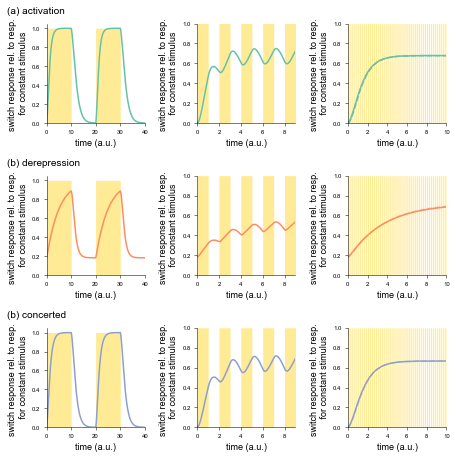

In [75]:
fig, axs = plt.subplots(3, 3,figsize=(469/72.27,469/72.27))

tmax = 40

TonSlow=10
ToffSlow=10

TonMod=1
ToffMod=1

TonFast=0.1
ToffFast=0.1

# activation
k1=1
k2=1
k3act=0
k4act=1
k5act=0.1
k6act=0
XT=100
YT=100
Sact=0.1

XssAct,YssAct = getXssYss(k1, k2, k3act, k4act, k5act, k6act, XT, YT, Sact)



axs[0,0].text(-0.4,1.1,'(a) activation',transform=axs[0,0].transAxes,fontsize=10)

tsol_act_Slow,xsol_act_Slow,Ssol_act_Slow=solODEPulseXY(k1, k2, k3act, k4act, k5act, k6act, XT, YT, Sact, TonSlow, ToffSlow, tmax)
#axs[0,0].plot(tsol_act_Slow,xsol_act_Slow[:,0]/XssAct,color='k',alpha=0.5,linestyle='--')
axs[0,0].plot(tsol_act_Slow,xsol_act_Slow[:,1]/YssAct,color=colors[0])
axs[0,0].fill_between(tsol_act_Slow,10*Ssol_act_Slow,color=colors[5],linewidth=0.1,alpha=0.5)


for idx in range(0,3):
    axs[idx,0].set_xlim(0,40)
    axs[idx,0].set_ylim(0,1.05)
    axs[idx,0].set_xlabel('time (a.u.)')
    axs[idx,0].set_ylabel('switch response rel. to resp. \n for constant stimulus')


tsol_act_Mod,xsol_act_Mod,Ssol_act_Mod=solODEPulseXY(k1, k2, k3act, k4act, k5act, k6act, XT, YT, Sact, TonMod, ToffMod, tmax)
#axs[0,1].plot(tsol_act_Mod,xsol_act_Mod[:,0]/XssAct,color='k',alpha=0.5,linestyle='--')
axs[0,1].plot(tsol_act_Mod,xsol_act_Mod[:,1]/YssAct,color=colors[0])
axs[0,1].fill_between(tsol_act_Mod,10*Ssol_act_Mod,color=colors[5],linewidth=0.1,alpha=0.5)


for idx in range(0,3):
    axs[idx,1].set_xlim(0,9)
    axs[idx,1].set_ylim(0,1)
    axs[idx,1].set_xlabel('time (a.u.)')
    axs[idx,1].set_ylabel('switch response rel. to resp. \n for constant stimulus')
    

tsol_act_Fast,xsol_act_Fast,Ssol_act_Fast=solODEPulseXY(k1, k2, k3act, k4act, k5act, k6act, XT, YT, Sact, TonFast, ToffFast, tmax)
#axs[0,2].plot(tsol_act_Fast,xsol_act_Fast[:,0]/XssAct,color='k',alpha=0.5,linestyle='--')
axs[0,2].plot(tsol_act_Fast,xsol_act_Fast[:,1]/YssAct,color=colors[0])
axs[0,2].fill_between(tsol_act_Fast,10*Ssol_act_Fast,color=colors[5],linewidth=0.1,alpha=0.5)


tsol_act_Const,xsol_act_const=solXYODEConstant(k1, k2, k3act, k4act, k5act, k6act, XT, YT, Sact/2, TonFast, ToffFast, tmax)
#axs[0,2].plot(tsol_act_Const,xsol_act_const[:,0]/XssAct,color='k',alpha=0.5,linestyle='--')
axs[0,2].plot(tsol_act_Const,xsol_act_const[:,1]/YssAct,color=colors[0],linestyle='--')

axs[0,2].set_xlim(0,10)
axs[0,2].set_ylim(0,1)
axs[0,2].set_xlabel('time (a.u.)')
axs[0,2].set_ylabel('switch response rel. to resp. \n for constant stimulus')



axs[1,0].text(-0.4,1.1,'(b) derepression',transform=axs[1,0].transAxes,fontsize=10)


# derepression
k1=1
k2=1
k3rep=1/9
k4rep=0
k5rep=0
k6rep=80/8100
XT=100
YT=100
Srep=10

XssRep,YssRep = getXssYss(k1, k2, k3rep, k4rep, k5rep, k6rep, XT, YT, Srep)



tsol_rep_Slow,xsol_rep_Slow,Ssol_rep_Slow=solODEPulseXY(k1, k2, k3rep, k4rep, k5rep, k6rep, XT, YT, Srep, TonSlow, ToffSlow, tmax)
#axs[1,0].plot(tsol_rep_Slow,xsol_rep_Slow[:,0]/XssRep,color='k',alpha=0.5,linestyle='--')
axs[1,0].plot(tsol_rep_Slow,xsol_rep_Slow[:,1]/YssRep,color=colors[1])
axs[1,0].fill_between(tsol_rep_Slow,0.1*Ssol_rep_Slow,color=colors[5],linewidth=0.1,alpha=0.5)



tsol_rep_Med,xsol_rep_Med,Ssol_rep_Med=solODEPulseXY(k1, k2, k3rep, k4rep, k5rep, k6rep, XT, YT, Srep, TonMod, ToffMod, tmax)
#axs[1,1].plot(tsol_rep_Med,xsol_rep_Med[:,0]/XssRep,color='k',alpha=0.5,linestyle='--')
axs[1,1].plot(tsol_rep_Med,xsol_rep_Med[:,1]/YssRep,color=colors[1])
axs[1,1].fill_between(tsol_rep_Med,0.1*Ssol_rep_Med,color=colors[5],linewidth=0.1,alpha=0.5)
axs[1,1].set_xlim(0,9)


tsol_rep_Fast,xsol_rep_Fast,Ssol_rep_Fast=solODEPulseXY(k1, k2, k3rep, k4rep, k5rep, k6rep, XT, YT, Srep, TonFast, ToffFast, tmax)
#axs[1,2].plot(tsol_rep_Fast,xsol_rep_Fast[:,0]/XssRep,color='k',alpha=0.5,linestyle='--')
axs[1,2].plot(tsol_rep_Fast,xsol_rep_Fast[:,1]/YssRep,color=colors[1])
axs[1,2].fill_between(tsol_rep_Fast,Ssol_rep_Fast/10,color=colors[5],linewidth=0.1,alpha=0.5)




tsol_rep_Const,xsol_rep_const=solXYODEConstant(k1, k2, k3rep, k4rep, k5rep, k6rep, XT, YT, Srep/2, TonFast, ToffFast, tmax)
axs[1,2].plot(tsol_rep_Const,xsol_rep_const[:,1]/YssRep,color=colors[1],alpha=0.5,linestyle='--')
#axs[1,2].plot(tsol_rep_Const,xsol_rep_const[:,0]/XssRep,color='k',alpha=0.5,linestyle='--')


for idx in range(0,3):
    axs[idx,2].set_xlim(0,10)
    axs[idx,2].set_ylim(0,1)
    axs[idx,2].set_xlabel('time (a.u.)')
    axs[idx,2].set_ylabel('switch response rel. to resp. \n for constant stimulus')

# concerted
k1=1
k2=1
k3conc=0
k4conc=0
k5conc=1/100
k6conc=1/100
XT=100
YT=100
Sconc=1

Xssconc,Yssconc = getXssYss(k1, k2, k3conc, k4conc, k5conc, k6conc, XT, YT, Sconc)

axs[2,0].text(-0.4,1.1,'(b) concerted',transform=axs[2,0].transAxes,fontsize=10)


tsol_conc_Slow,xsol_conc_Slow,Ssol_conc_Slow=solODEPulseXY(k1, k2, k3conc, k4conc, k5conc, k6conc, XT, YT, Sconc, TonSlow, ToffSlow, tmax)
#axs[2,0].plot(tsol_conc_Slow,xsol_conc_Slow[:,0]/Xssconc,color='k',alpha=0.5,linestyle='--')
axs[2,0].plot(tsol_conc_Slow,xsol_conc_Slow[:,1]/Yssconc,color=colors[2])
axs[2,0].fill_between(tsol_conc_Slow,Ssol_conc_Slow,color=colors[5],linewidth=0.1,alpha=0.5)



tsol_conc_Med,xsol_conc_Med,Ssol_conc_Med=solODEPulseXY(k1, k2, k3conc, k4conc, k5conc, k6conc, XT, YT, Sconc, TonMod, ToffMod, tmax)
#axs[2,1].plot(tsol_conc_Med,xsol_conc_Med[:,0]/Xssconc,color='k',alpha=0.5,linestyle='--')
axs[2,1].plot(tsol_conc_Med,xsol_conc_Med[:,1]/Yssconc,color=colors[2])
axs[2,1].fill_between(tsol_conc_Med,Ssol_conc_Med,color=colors[5],linewidth=0.1,alpha=0.5)

axs[2,1].set_xlim(0,9)


tsol_conc_Fast,xsol_conc_Fast,Ssol_conc_Fast=solODEPulseXY(k1, k2, k3conc, k4conc, k5conc, k6conc, XT, YT, Sconc, TonFast, ToffFast, tmax)
#axs[2,2].plot(tsol_conc_Fast,xsol_conc_Fast[:,0]/Xssconc,color='k',alpha=0.5,linestyle='--')
axs[2,2].plot(tsol_conc_Fast,xsol_conc_Fast[:,1]/Yssconc,color=colors[2])
axs[2,2].fill_between(tsol_conc_Fast,Ssol_conc_Fast,color=colors[5],linewidth=0.1,alpha=0.5)


tsol_conc_Const,xsol_conc_const=solXYODEConstant(k1, k2, k3conc, k4conc, k5conc, k6conc, XT, YT, Sconc/2, TonFast, ToffFast, tmax)
axs[2,2].plot(tsol_conc_Const,xsol_conc_const[:,1]/Yssconc,color=colors[2],alpha=0.5,linestyle='--')
#axs[2,2].plot(tsol_conc_Const,xsol_conc_const[:,0]/Xssconc,color='k',alpha=0.5,linestyle='--')



plt.tight_layout()

plt.savefig('switch.pdf')

# Activation versus derepression

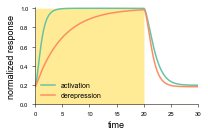

In [7]:
plt.figure(figsize=(3,2))
# Fig 3C
# activation
k1=1
k2=1
k3a=1/9
k4a=1
k5a=0.1
k6a=0
XT=100
YT=100
Sa=0.1

Ton=20
Toff=10
tmax=Ton+Toff

XssAct,YssAct = getXssYss(k1, k2, k3a, k4a, k5a, k6a, XT, YT, Sa)



tsol_act_Slow,xsol_act_Slow,Ssol_act_Slow=solODEPulseXY(k1, k2, k3a, k4a, k5a, k6a, XT, YT, Sa, Ton, Toff, tmax)
#plt.plot(tsol_act_Slow,xsol_act_Slow[:,0]/XssAct,color='k',alpha=0.5,linestyle='--')
plt.plot(tsol_act_Slow,xsol_act_Slow[:,1]/YssAct,color=colors[0],label='activation')
plt.fill_between(tsol_act_Slow,10*Ssol_act_Slow,color=colors[5],linewidth=0.1,alpha=0.5)


# derepression

k1=1
k2=1
k3r=1/9
k4r=0
k5r=0
k6r=80/8100
XT=100
YT=100
Sr=10

XssR,YssR = getXssYss(k1, k2, k3r, k4r, k5r, k6r, XT, YT, Sr)



tsol_rep_Slow,xsol_rep_Slow,Ssol_rep_Slow=solODEPulseXY(k1, k2, k3r, k4r, k5r, k6r, XT, YT, Sr, Ton, Toff, tmax)
#plt.plot(tsol_rep_Slow,xsol_rep_Slow[:,0]/XssR,color='k',alpha=0.5,linestyle='--')
plt.plot(tsol_rep_Slow,xsol_rep_Slow[:,1]/YssR,color=colors[1],label='derepression')
plt.xlim(0,30)
plt.ylim(0,1.01)

plt.xlabel('time')
plt.ylabel('normalized response')
plt.legend(loc='best',frameon=False,fontsize=7)

plt.tight_layout()

plt.savefig('fig3c.pdf',bbox_inches = 'tight', pad_inches = 0)

In [8]:
(1/9+1)/(1/9+1+10)

0.1